# 00_explore_datasets_plantdoc

**Objective:**  
Explore and validate the PlantDoc dataset for object detection tasks.
- Verify annotation and image alignment
- Inspect class distribution
- Visualize a few annotated samples


Each image has a matching Pascal VOC XML annotation — ideal for training object detection or segmentation models (e.g., YOLOv8-Seg, SAM2, or Faster R-CNN).

In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw
from tqdm import tqdm

# Paths
TRAIN_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\PlantDoc_repo_new\TRAIN")
TEST_DIR  = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\PlantDoc_repo_new\TEST")

# Quick check
print("Train folder:", len(list(TRAIN_DIR.glob('*.jpg'))), "images")
print("Test folder:", len(list(TEST_DIR.glob('*.jpg'))), "images")


Train folder: 1577 images
Test folder: 234 images


Parse XML notations

In [ ]:
def parse_voc_annotation(xml_file):
    """Safely parse a Pascal VOC XML annotation file."""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find("filename").text if root.find("filename") is not None else xml_file.stem + ".jpg"
        objects = []

        for obj in root.findall("object"):
            label = obj.find("name").text if obj.find("name") is not None else "unknown"
            bbox = obj.find("bndbox")
            if bbox is not None:
                try:
                    xmin = int(float(bbox.find("xmin").text))
                    ymin = int(float(bbox.find("ymin").text))
                    xmax = int(float(bbox.find("xmax").text))
                    ymax = int(float(bbox.find("ymax").text))
                    objects.append((label, xmin, ymin, xmax, ymax))
                except Exception:
                    # Skip objects with malformed coordinates
                    continue
            else:
                # skip missing bounding box
                continue

        return filename, objects

    except Exception as e:
        print(f"Skipping {xml_file.name}: {e}")
        return xml_file.name, []


# parse a few samples
sample_xmls = list(TRAIN_DIR.glob('*.xml'))[:5]
for xml_file in sample_xmls:
    filename, objects = parse_voc_annotation(xml_file)
    print(f"File: {filename}, Objects: {objects}")

File: 0.jpg, Objects: [('Bell_pepper leaf spot', 28, 30, 105, 140), ('Bell_pepper leaf spot', 127, 66, 212, 152), ('Bell_pepper leaf spot', 95, 107, 130, 168), ('Bell_pepper leaf spot', 1, 159, 103, 226), ('Bell_pepper leaf spot', 108, 187, 178, 297), ('Bell_pepper leaf spot', 118, 152, 176, 185)]
File: 0000.jpg, Objects: [('Bell_pepper leaf spot', 761, 115, 1987, 1591), ('Bell_pepper leaf spot', 1478, 565, 2573, 1944)]
File: 00009.jpg, Objects: [('Potato leaf early blight', 93, 8, 342, 524)]
File: 0008003-strawberry-leaf-veiner-large.jpg, Objects: [('Strawberry leaf', 734, 414, 1069, 661), ('Strawberry leaf', 905, 179, 1196, 545), ('Strawberry leaf', 938, 523, 1218, 854), ('Strawberry leaf', 734, 634, 1027, 1005), ('Strawberry leaf', 718, 8, 1070, 245)]
File: 000g.jpg, Objects: [('grape leaf', 189, 122, 821, 800), ('grape leaf', 708, 7, 1019, 335), ('grape leaf', 754, 340, 1126, 671)]


Create a dataframe of all annotations

In [13]:
records = []

for xml_file in tqdm(TRAIN_DIR.glob('*.xml'), desc="Parsing Train Annotations"):
    filename, objects = parse_voc_annotation(xml_file)
    for label, xmin, ymin, xmax, ymax in objects:
        records.append({
            "image" : filename,
            "label" : label,
            "xmin"  : xmin,
            "xmax"  : xmax,
            "ymin"  : ymin,
            "ymax"  : ymax
        })

df = pd.DataFrame(records)
print("Total annotations parsed:", len(df))
df.head()

Parsing Train Annotations: 1577it [00:01, 1320.74it/s]

Total annotations parsed: 5330


,image,label,xmin,xmax,ymin,ymax
0,0.jpg,Bell_pepper leaf spot,28,105,30,140
1,0.jpg,Bell_pepper leaf spot,127,212,66,152
2,0.jpg,Bell_pepper leaf spot,95,130,107,168
3,0.jpg,Bell_pepper leaf spot,1,103,159,226
4,0.jpg,Bell_pepper leaf spot,108,178,187,297


Check dataset consistency:

In [14]:
# count missing or mismatched annotations
missing_annotations = 0
image_files = {p.stem for p in TRAIN_DIR.glob('*.jpg')}
xml_files = {p.stem for p in TRAIN_DIR.glob('*.xml')}

missing_xml = image_files - xml_files
missing_images = xml_files - image_files

print(f"Missing XML annotations for {len(missing_xml)} images.")
print(f"Missing images for {len(missing_images)} XML files.")

Missing XML annotations for 2 images.
Missing images for 2 XML files.


Label distribution

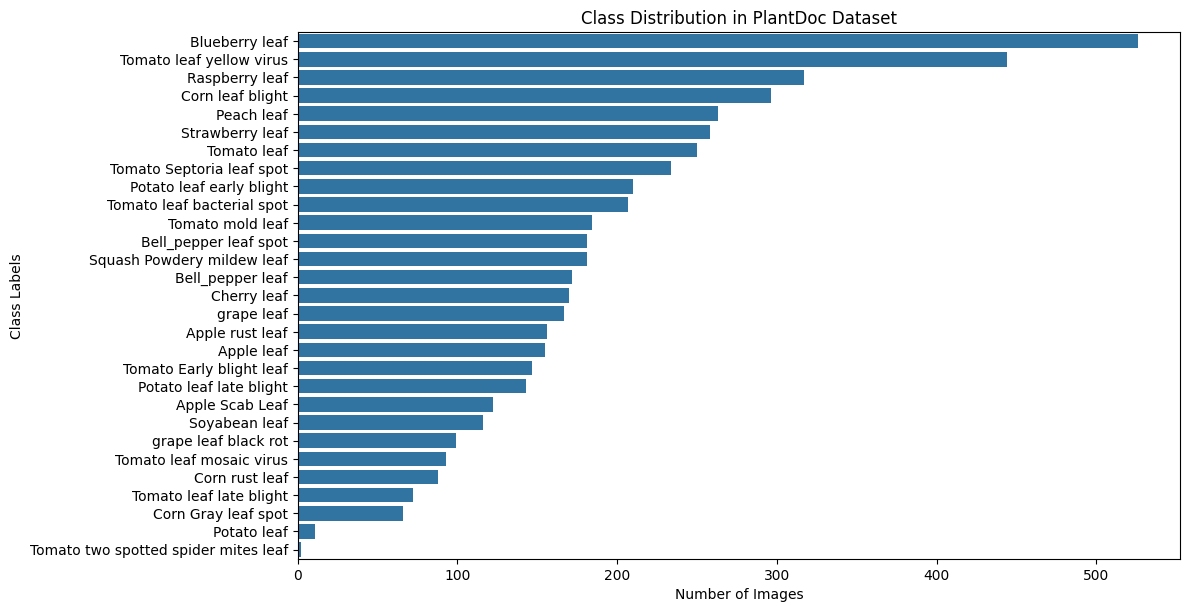

In [15]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y = "label", order=df['label'].value_counts().index)
plt.tight_layout()
plt.title("Class Distribution in PlantDoc Dataset")
plt.xlabel("Number of Images")
plt.ylabel("Class Labels")
plt.show()

Visualize bounding boxes

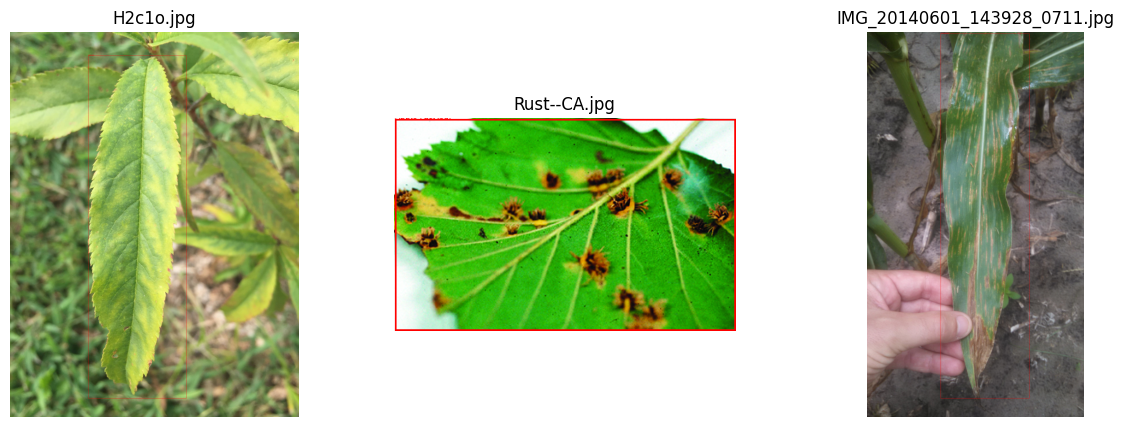

In [ ]:
import random  # Used for selecting random samples

def show_random_bbox(n=3):
    """
    Display 'n' random images from the PlantDoc dataset with their annotated bounding boxes.
    
    Parameters
    ----------
    n : int
        Number of random images to display (default = 3)
    
    Description
    -----------
    This function randomly selects 'n' unique image names from the dataframe 'df',
    loads each corresponding image from TRAIN_DIR, overlays the bounding boxes 
    and labels from the annotations DataFrame, and displays them in a row of subplots.
    """

    # Randomly select 'n' unique image filenames from the 'image' column of df
    samples = random.sample(df["image"].unique().tolist(), n)

    # Create a matplotlib figure to hold all subplots
    plt.figure(figsize=(15, 5))

    # Enumerate through each selected image
    for i, img_name in enumerate(samples):
        # Construct the full path to the image file
        img_path = TRAIN_DIR / img_name

        # Filter all annotation rows that belong to this specific image
        annots = df[df["image"] == img_name]

        # Open the image with PIL and ensure it's in RGB format
        img = Image.open(img_path).convert("RGB")

        # Create a drawable overlay on the image (for bounding boxes and text)
        draw = ImageDraw.Draw(img)

        # Iterate through all bounding boxes for this image
        for _, row in annots.iterrows():
            # Draw a red rectangle for each bounding box
            draw.rectangle(
                [row["xmin"], row["ymin"], row["xmax"], row["ymax"]],
                outline="red",   # box color
                width=2          # line thickness
            )

            # Write the label text slightly above the bounding box
            draw.text(
                (row["xmin"], row["ymin"] - 10),
                row["label"],
                fill="red"       # text color
            )

        # Add this annotated image as a subplot in the figure
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")        # Hide axes for clarity
        plt.title(img_name)    # Display the filename as the title

    # Render all subplots at once
    plt.show()

# Display 3 random annotated samples to visually confirm the parsing
show_random_bbox(3)


##  Summary

- Dataset parsed successfully.
- No major missing annotation issues (minor mismatches may exist).
- Label distribution shows most frequent diseases.
- Bounding box annotations visualize correctly.
- Ready for conversion to YOLO or COCO format in the preprocessing notebook.
